In [1]:
# Loading packages and data
# See: https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated, partition
using Printf, BSON
using ImageView
using Plots

# Load labels and images from Flux.Data.MNIST
# Train set: images used to estimate the CNN
# Load data on gpu (if enabled)
train_labels = gpu.(MNIST.labels(:train))
train_imgs = gpu.(MNIST.images(:train));

# Test set: images used to see how well the CNN perform "out-of-the-sample"
test_imgs = MNIST.images(:test)
test_labels = MNIST.labels(:test)

print("Images in the train set: $(size(train_imgs))")
print("Images in the test set: $(size(test_imgs))")

# Visualization of one digit
NROWS, NCOLS = 28, 28
a = reshape(train_imgs[1], NROWS, NCOLS)

Images in the train set: (60000,)Images in the test set: (10000,)

┌ Warning: Flux's datasets are deprecated, please use the package MLDatasets.jl
└ @ Flux.Data /Users/usmanasim/.julia/packages/Flux/qAdFM/src/data/Data.jl:16
┌ Info: The GPU function is being called but the GPU is not accessible. 
│ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
└ @ Flux /Users/usmanasim/.julia/packages/Flux/qAdFM/src/functor.jl:187
┌ Warning: Flux's datasets are deprecated, please use the package MLDatasets.jl
└ @ Flux.Data /Users/usmanasim/.julia/packages/Flux/qAdFM/src/data/Data.jl:16
┌ Warning: Flux's datasets are deprecated, please use the package MLDatasets.jl
└ @ Flux.Data /Users/usmanasim/.julia/packages/Flux/qAdFM/src/data/Data.jl:16
┌ Warning: Flux's datasets are deprecated, please use the package MLDatasets.jl
└ @ Flux.Data /Users/usmanasim/.julia/packages/Flux/qAdFM/src/data/Data.jl:16


In [2]:
import Pkg; Pkg.add("Printf")
# import Pkg; Pkg.status()

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `/Volumes/GoogleDrive/My Drive/UNOMIC/JuliaTesting/Julia/cifar10conv/Project.toml`
  No Changes to `/Volumes/GoogleDrive/My Drive/UNOMIC/JuliaTesting/Julia/cifar10conv/Manifest.toml`


In [3]:
model = Chain(
    # First convolution, operating upon a 28x28 image
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    MaxPool((2,2)), #maxpooling

    # Second convolution, operating upon a 14x14 image
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)), #maxpooling

    # Third convolution, operating upon a 7x7 image
    Conv((3, 3), 32=>32,pad=(1,1), relu),
    MaxPool((2,2)),

    # Reshape 3d tensor into a 2d one, at this point it should be (3, 3, 32, N)
    # which is where we get the 288 in the `Dense` layer below:
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 10),

    # Softmax to get probabilities
    softmax,
)

# Load on gpu (if available)
# model = gpu(model);

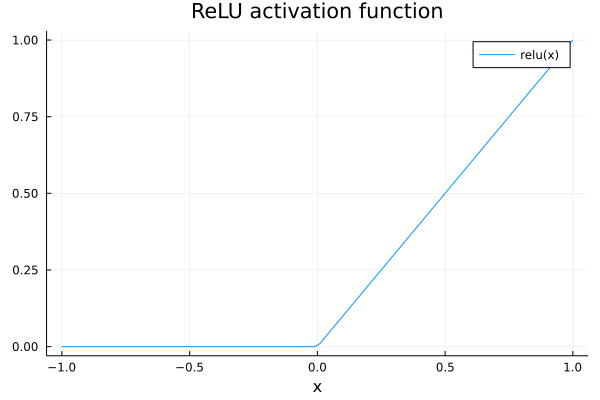

In [4]:
xgrid = collect(range(-1, 1, length=100)) 
plot(xgrid, NNlib.relu.(xgrid), label = "relu(x)", title="ReLU activation function", xlabel="x")

In [5]:
# Batching 
# See: https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl
# Bundle images together with labels and group into minibatchess
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, size(X[1])..., 1, length(idxs))
    for i in 1:length(idxs)
        X_batch[:, :, :, i] = Float32.(X[idxs[i]])
    end
    Y_batch = onehotbatch(Y[idxs], 0:9)
    return (X_batch, Y_batch)
end
# The CNN only "sees" 128 images at each training cycle:
batch_size = 128
mb_idxs = partition(1:length(train_imgs), batch_size)
# train set in the form of batches
train_set = [make_minibatch(train_imgs, train_labels, i) for i in mb_idxs];
# train set in one-go: used to calculate accuracy with the train set
train_set_full = make_minibatch(train_imgs, train_labels, 1:length(train_imgs));
# test set: to check we do not overfit the train data:
test_set = make_minibatch(test_imgs, test_labels, 1:length(test_imgs));

In [6]:
# Loss function
# See: https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl
# `loss()` calculates the crossentropy loss between our prediction `y_hat`
function loss(x, y)
    # Add some noise to the image
    # we reduce the risk of overfitting the train sample by doing so:
    x_aug = x .+ 0.1f0*gpu(randn(eltype(x), size(x)))

    y_hat = model(x_aug)
    return crossentropy(y_hat, y)
end
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

# ADAM optimizer
opt = ADAM(0.001);

In [7]:
# Training loop
# See: https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl
best_acc = 0.0
last_improvement = 0
accuracy_target = 0.97 #Set an accuracy target. When reached, we stop training.
max_epochs = 100 #Maximum
for epoch_idx in 1:10
    print("Training Starting")
    global best_acc, last_improvement
    # Train for a single epoch
    Flux.train!(loss, params(model), train_set, opt)

    # Calculate accuracy:
    acc = accuracy(train_set_full...)
    @info(@sprintf("[%d]: Train accuracy: %.4f", epoch_idx, acc))
    
    # Calculate accuracy:
    acc = accuracy(test_set...)
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch_idx, acc))

    # If our accuracy is good enough, quit out.
    if acc >= accuracy_target
        @info(" -> Early-exiting: We reached our target accuracy of $(accuracy_target*100)%")
        break
    end

    if epoch_idx - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

Training StartingTraining Starting

┌ Info: [1]: Train accuracy: 0.9537
└ @ Main In[7]:15
┌ Info: [1]: Test accuracy: 0.9573
└ @ Main In[7]:19
┌ Info: [2]: Train accuracy: 0.9753
└ @ Main In[7]:15
┌ Info: [2]: Test accuracy: 0.9757
└ @ Main In[7]:19
┌ Info:  -> Early-exiting: We reached our target accuracy of 97.0%
└ @ Main In[7]:23
